In [1]:
import os
import re
import pytorch_lightning as pl
import torch
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import Pad
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import numpy as np
from torchvision.utils import make_grid

from matplotlib import pyplot as plt
%matplotlib inline

In [30]:
BATCH_SIZE = 16
DATA_DIR = '../data/raw'
MODEL_DIR = '../models'
PIC_DIR = '../data/external'
IMG_SIZE = 224
LATENT_DIM = 128
LR = 2e-4
NUM_EPOCHS = 100

In [31]:
# the function for weights initialization has been taken from there 
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [61]:
def make_samples(model, num_preds=16):

    z = torch.randn(num_preds, model.latent_dim)

    with torch.no_grad():
        pred = model(z)

    pred = pred * 0.5 + 0.5
    grid = make_grid(pred).permute(1, 2, 0).numpy()

    return grid


def save_im(grid, pic_dir):

    p = re.compile(r'img_\d*[.]jpg')
    list_imgs = list(filter(lambda pth:  p.match(pth),
                            os.listdir(pic_dir)))

    nums = list(map(lambda pth: int(pth.split('img_')[-1]
                                    .split('.')[0]),
                    list_imgs))

    if nums:
        num = max(nums) + 1
    else:
        num = 0

    pic_name = 'img_{}.jpg'.format(num)
    path = os.path.join(pic_dir, pic_name)

    fig = plt.figure(figsize=(8, 3), dpi=300)
    plt.imshow(grid)
    plt.savefig(path)
    plt.close(fig)

In [33]:
def save_model(trainer, model_dir, model_name='model.ckpt'):
    path = os.path.join(model_dir, model_name)
    trainer.save_checkpoint(path)


def load_model(model_dir, img_size, latent_dim, lr,
               model_name='model.ckpt'):
    path = os.path.join(model_dir, model_name)
    model = DCGAN.load_from_checkpoint(checkpoint_path=path,
                                       img_size=img_size,
                                       latent_dim=latent_dim,
                                       lr=lr)
    return model

In [34]:
class WhiteSpacePad:
    def __call__(self, pic):
        pic_size = pic.size
        max_size = max(pic.size)
        horiz_pad, ver_pad = tuple(map(lambda size: (max_size - size) / 2,
                                       pic_size))
        padding = (int(np.floor(horiz_pad)), int(np.floor(ver_pad)),
                   int(np.ceil(horiz_pad)), int(np.ceil(ver_pad)))
        pad = Pad(padding, fill=255, padding_mode='constant')
        return pad(pic)

In [35]:
class DataModule(pl.LightningDataModule):
    def __init__(self, data_dir, img_size, batch_size):
        super().__init__()
          
        self.data_dir = data_dir
        self.img_size = img_size
        self.batch_size = batch_size
          
        self.transform = transforms.Compose([WhiteSpacePad(),
                                            transforms.Resize(self.img_size),
                                            transforms.RandomHorizontalFlip(0.5),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                           ])
  
    def setup(self, stage=None):
             
        self.train_data = datasets.ImageFolder(self.data_dir, 
                                               transform=self.transform)
  
    def train_dataloader(self):
        
        return DataLoader(self.train_data, 
                          batch_size = self.batch_size,
                          shuffle=True)

In [36]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_size):
        super().__init__()
        self.img_size = img_size
        self.start_size = self.img_size // 16
        self.fc_layer = nn.Sequential(
            nn.Linear(latent_dim, 512 * (self.start_size ** 2)),
            nn.LeakyReLU(0.2, inplace=True))
        self.conv_layers = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, 4, stride=1, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 4, stride=1, padding=2),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 4, stride=1, padding=2),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 3, 3, stride=1, padding=2),
            nn.Tanh()
        )

    def forward(self, x):
        out = self.fc_layer(x)
        out = out.view(out.shape[0], 512,
                       self.start_size,
                       self.start_size)
        out = self.conv_layers(out)
        return out

In [37]:
class Discriminator(nn.Module):
    def __init__(self, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.fin_size = self.img_size // 16
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(512 * (self.fin_size ** 2), 1),
            nn.Sigmoid())

    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(out.shape[0], -1)
        out = self.fc_layer(out)
        return out

In [38]:
class DCGAN(pl.LightningModule):

    def __init__(self,
                 img_size,
                 latent_dim=128,
                 lr=0.0002,
                 beta_1=0.5,
                 beta_2=0.999,
                 **kwargs):
        super().__init__()

        self.img_size = img_size
        self.latent_dim = latent_dim
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2

        self.generator = Generator(latent_dim=self.latent_dim,
                                   img_size=self.img_size)
        self.discriminator = Discriminator(img_size=self.img_size)
        self.generator.apply(weights_init)
        self.discriminator.apply(weights_init)

    def forward(self, x):
        return self.generator(x)

    def adversarial_loss(self, y_pred, y_true):
        return F.binary_cross_entropy(y_pred, y_true)

    def training_step(self, batch, batch_idx, optimizer_idx):
        real_imgs, _ = batch
        z = torch.randn(len(real_imgs), self.latent_dim).type_as(real_imgs)
        fake_imgs = self(z)

        if optimizer_idx == 0:

            y_true = torch.ones(len(z), 1).type_as(real_imgs)
            y_pred = self.discriminator(fake_imgs)
            g_loss = self.adversarial_loss(y_pred, y_true)
            self.log_dict({
                        'g_loss': g_loss,
                    })
            return g_loss

        elif optimizer_idx == 1:

            y_true_r = torch.ones(len(real_imgs), 1).type_as(real_imgs)
            y_pred_r = self.discriminator(real_imgs)
            real_loss = self.adversarial_loss(y_pred_r, y_true_r)

            y_true_f = torch.zeros(len(real_imgs), 1).type_as(real_imgs)
            y_pred_f = self.discriminator(fake_imgs.detach())
            fake_loss = self.adversarial_loss(y_pred_f, y_true_f)

            d_loss = (real_loss + fake_loss) / 2

            with torch.no_grad():
                real_acc = torch.round(y_pred_r).sum() / len(real_imgs)
                fake_acc = 1 - torch.round(y_pred_f).sum() / len(fake_imgs)

            d_loss = (real_loss + fake_loss) / 2
            self.log_dict({
                        'd_loss': d_loss,
                        'fake_loss': fake_loss,
                        'real_loss': real_loss,
                        'fake_acc': fake_acc,
                        'real_acc': real_acc,
                    })
            return d_loss

    def configure_optimizers(self):

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=self.lr,
                                 betas=(self.beta_1, self.beta_2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr,
                                 betas=(self.beta_1, self.beta_2))
        return [opt_g, opt_d], []

    def on_epoch_end(self):

        z = torch.randn(8, self.latent_dim).to(self.device)
        imgs = self(z)
        grid = torchvision.utils.make_grid(imgs)
        self.logger.experiment.add_image('guitars', grid, self.current_epoch)

In [39]:
datamodule = DataModule(DATA_DIR, IMG_SIZE, BATCH_SIZE)

In [11]:
pl.seed_everything(2023)

gan = DCGAN(IMG_SIZE, LATENT_DIM, LR)
trainer = pl.Trainer(gpus=1, max_epochs=NUM_EPOCHS)
trainer.fit(gan, datamodule)

Global seed set to 2023
/home/max/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/max/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `LightningModule.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `LightningModule.on_<train/validation/test>_epoch_end` instead.
  f"The `LightningModule.{hook}` hook was deprecated in v1.6 and"
Missing logger folder: /home/max/Projects/Neuroguitars/repo/neuroguitars/notebooks/lightning_lo

Training: 0it [00:00, ?it/s]

/home/max/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:657: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [21]:
save_model(trainer, MODEL_DIR)

In [40]:
gan = load_model(MODEL_DIR, img_size=IMG_SIZE, 
                 latent_dim=LATENT_DIM, lr=LR)

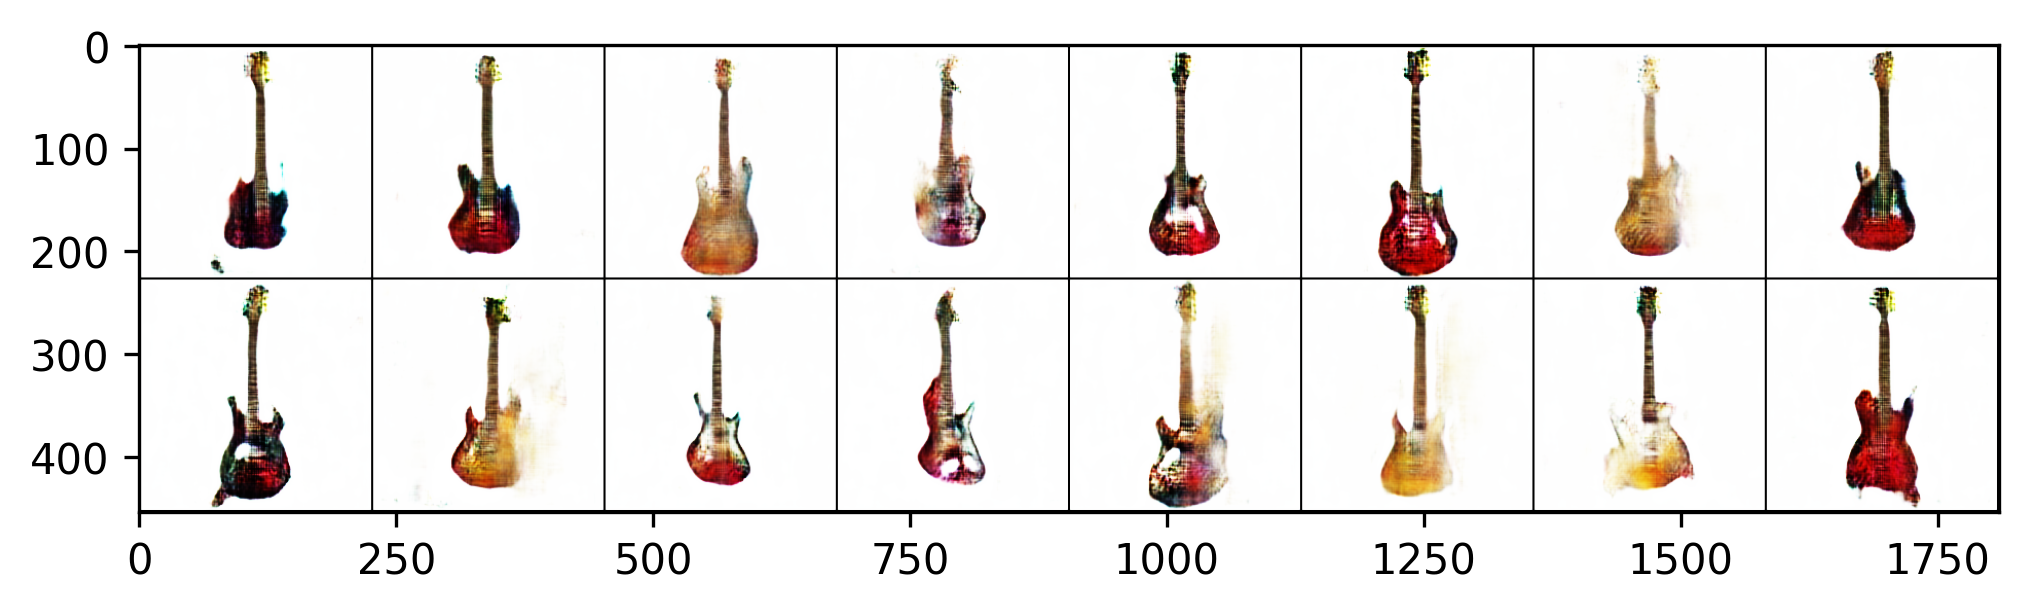

In [42]:
plt.figure(figsize=(8, 3), dpi=300)
grid = make_samples(gan)
plt.imshow(grid);

In [ ]:
save_im(grid, PIC_DIR)